Imports

In [1]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Loading Dataset

In [2]:
df = pd.read_csv('individual_bank_data.csv')

Dataset Preview

In [5]:
df.head()

Date      Index         Open         High          Low        Close
0  2023-01-02  HDFC Bank  1622.050049  1639.000000  1618.650024  1629.150024
1  2023-01-03  HDFC Bank  1624.550049  1643.599976  1624.550049  1639.699951
2  2023-01-04  HDFC Bank  1635.000000  1645.750000  1607.449951  1610.550049
3  2023-01-05  HDFC Bank  1614.300049  1618.199951  1590.000000  1599.699951
4  2023-01-06  HDFC Bank  1599.750000  1608.900024  1578.500000  1594.349976

Summary Statistics

In [6]:
# Get summary statistics
summary_stats = df.describe()
summary_stats


Open         High          Low        Close
count  2760.000000  2760.000000  2760.000000  2760.000000
mean    713.186311   719.292042   706.165200   712.836036
std     590.505681   594.732548   585.637656   590.290765
min      44.759998    45.750000    44.410000    44.919998
25%     156.950001   158.987499   153.724998   156.312496
50%     605.875000   611.450012   599.174988   605.225006
75%    1076.424957  1089.425018  1058.125000  1075.075043
max    1980.949951  2063.000000  1955.000000  1994.599976

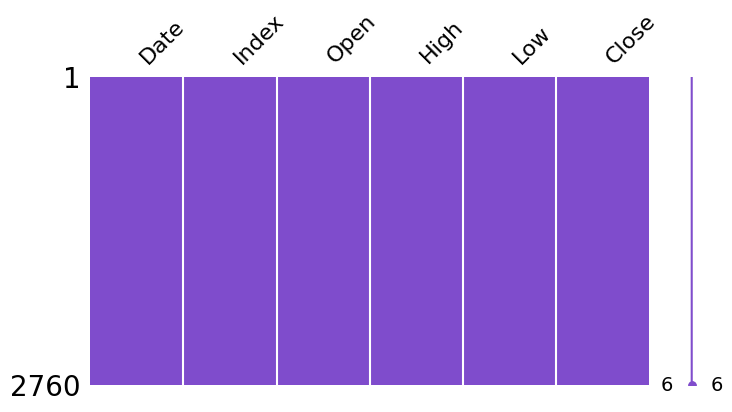

In [7]:
import missingno as msno
df = pd.read_csv('individual_bank_data.csv')
msno.matrix(df , color=(0.50,0.30,0.80),figsize=(8, 4))
plt.show()
x = df.isnull().sum()
for a, b in x.items():
 if b > 0:
     print(f"There are {b} missing values in column: {a}")

Derived Columns

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%Y-%m')

In [5]:
df['Daily_Return'] = df.groupby('Index')['Close'].pct_change()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_9'] = df['Close'].ewm(span=9, adjust=False).mean()
df['ATR'] = df.groupby('Index').apply(lambda x: (x['High'] - x['Low']).rolling(window=14).mean()).reset_index(level=0, drop=True)
df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
df['Volatility_14d'] = df.groupby('Index')['Daily_Return'].transform(lambda x: x.rolling(window=14).std())
df['Price_Range'] = df['High'] - df['Low']

C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19796\1609586393.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['ATR'] = df.groupby('Index').apply(lambda x: (x['High'] - x['Low']).rolling(window=14).mean()).reset_index(level=0, drop=True)


Mean Price Stats for Banks

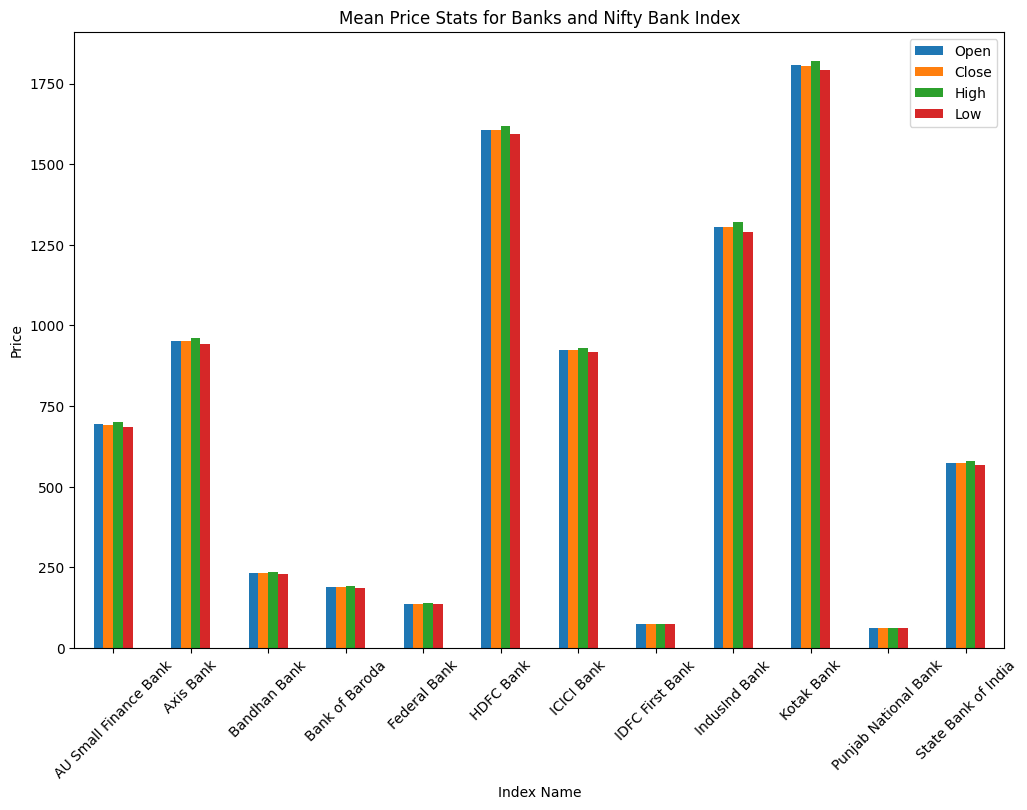

In [10]:
# Group by 'index name' and calculate mean open, close, high, low prices
mean_stats = df.groupby('Index')[['Open', 'Close', 'High', 'Low']].mean()

# Plot the mean statistics for each bank and the Nifty Bank Index
mean_stats.plot(kind='bar', figsize=(12, 8), title='Mean Price Stats for Banks and Nifty Bank Index')
plt.ylabel('Price')
plt.xlabel('Index Name')
plt.xticks(rotation=45)
plt.show()

Average Daily Price Range

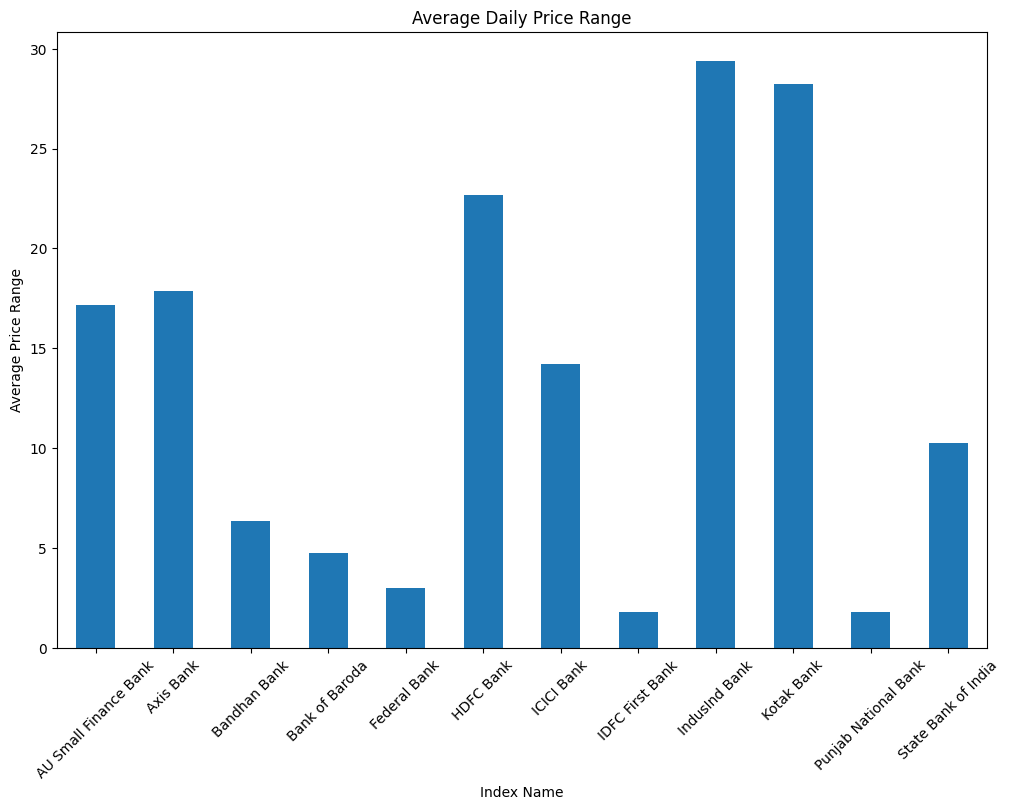

In [12]:
# Group by 'index name' and calculate average price range
df['price_range'] = df['High'] - df['Low']

mean_price_range = df.groupby('Index')['price_range'].mean()

# Plot the average price range for each bank and Nifty Bank Index
mean_price_range.plot(kind='bar', figsize=(12, 8), title='Average Daily Price Range')
plt.ylabel('Average Price Range')
plt.xlabel('Index Name')
plt.xticks(rotation=45)
plt.show()

Monthly Average Daily Returns

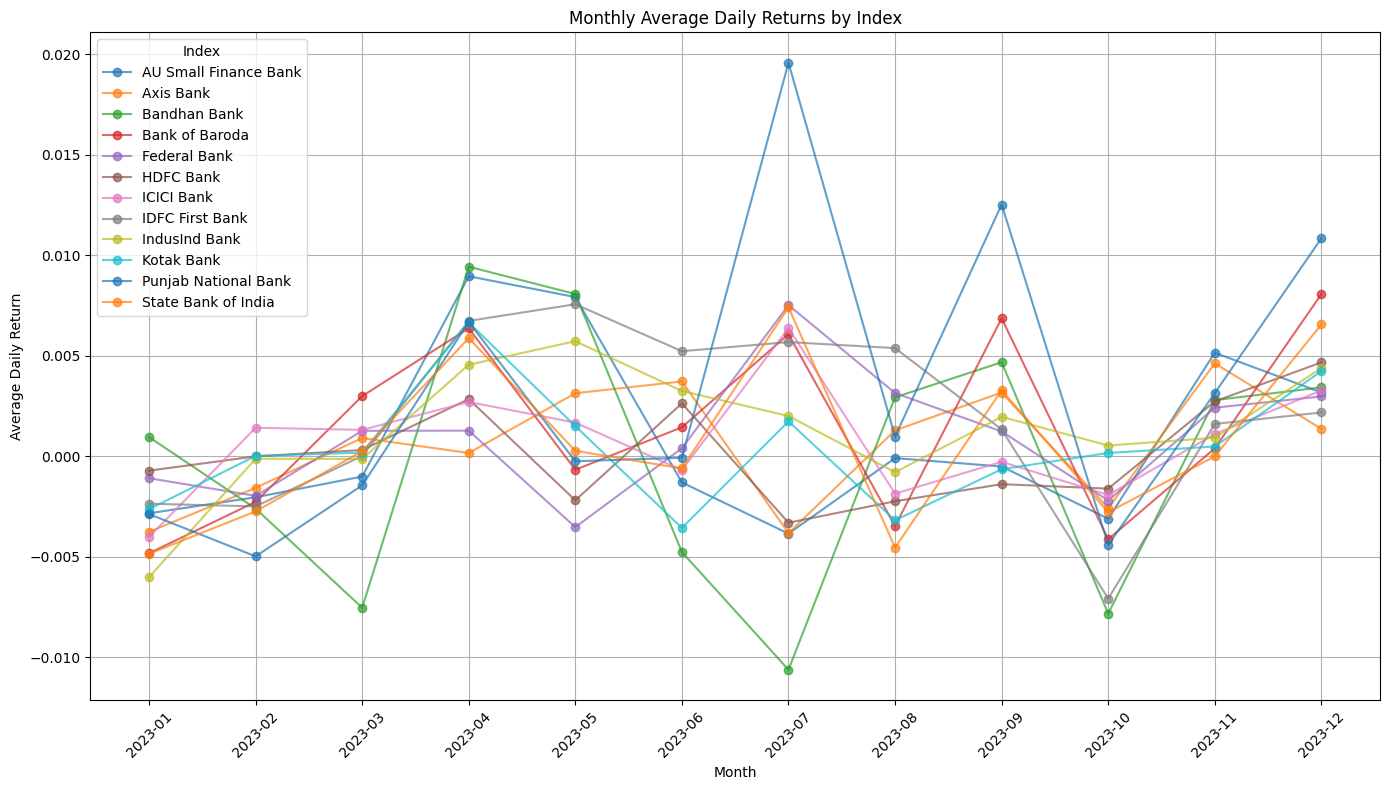

In [21]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Calculate daily returns for each bank and the Nifty Bank Index
df['daily_return'] = df.groupby('Index')['Close'].pct_change()

# Extract month and year from the 'Date' column
df['Month'] = df['Date'].dt.to_period('M')

# Group by month and index, then aggregate daily returns (mean for each month per index)
monthly_returns = df.groupby(['Index', 'Month'])['daily_return'].mean().reset_index()

# Plotting
plt.figure(figsize=(14, 8))
for name, group in monthly_returns.groupby('Index'):
    plt.plot(group['Month'].astype(str), group['daily_return'], marker='o', linestyle='-', alpha=0.7, label=name)

plt.title('Monthly Average Daily Returns by Index')
plt.xlabel('Month')
plt.ylabel('Average Daily Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Index')
plt.tight_layout()
plt.show()

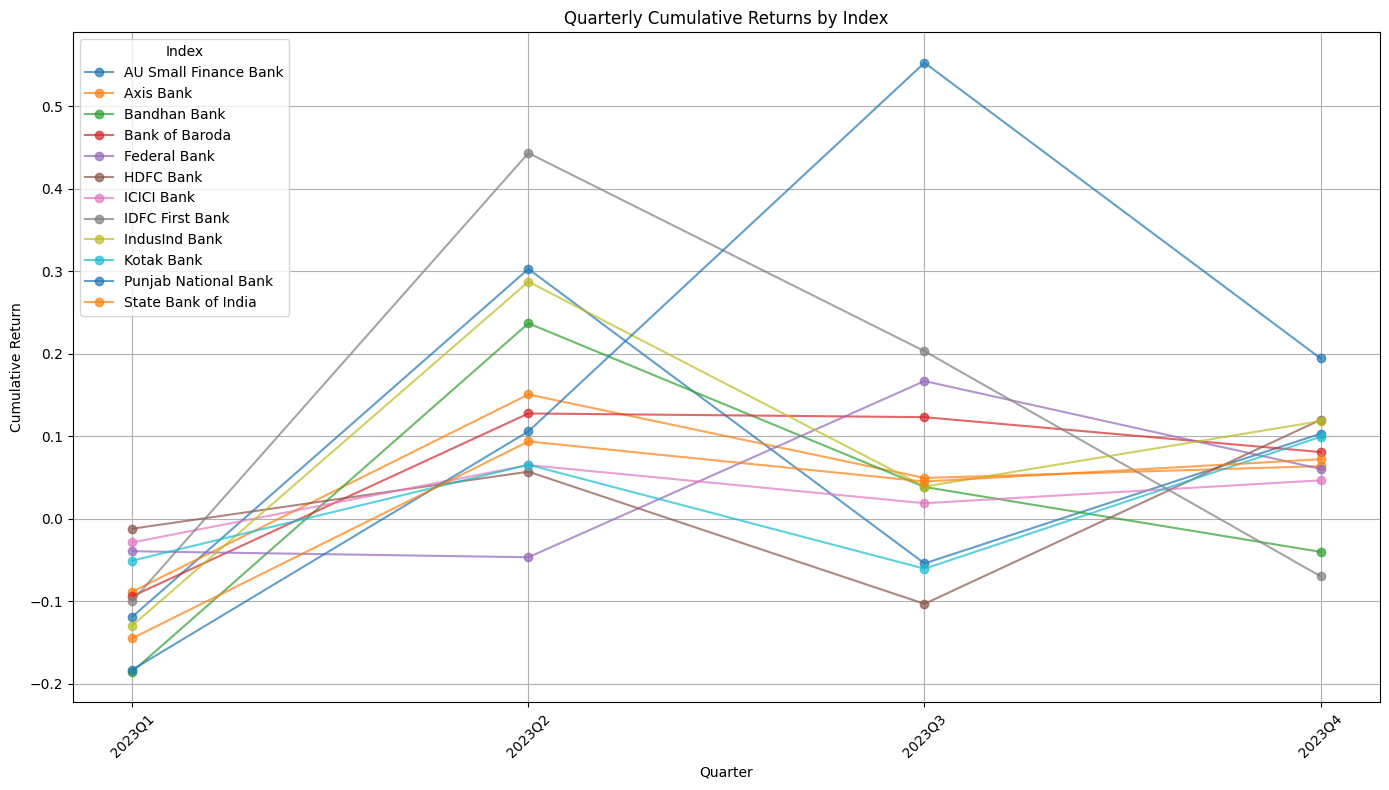

In [23]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Calculate daily returns for each bank and the Nifty Bank Index
df['daily_return'] = df.groupby('Index')['Close'].pct_change()

# Extract quarter and year from the 'Date' column
df['Quarter'] = df['Date'].dt.to_period('Q')

# Calculate quarterly returns: (1 + daily_return).prod() - 1 for each quarter per index
df['daily_return_adjusted'] = 1 + df['daily_return']  # Adjust to work with cumulative returns
quarterly_returns = df.groupby(['Index', 'Quarter'])['daily_return_adjusted'].prod() - 1

# Reset index for plotting
quarterly_returns = quarterly_returns.reset_index()

# Plotting
plt.figure(figsize=(14, 8))
for name, group in quarterly_returns.groupby('Index'):
    plt.plot(group['Quarter'].astype(str), group['daily_return_adjusted'], marker='o', linestyle='-', alpha=0.7, label=name)

plt.title('Quarterly Cumulative Returns by Index')
plt.xlabel('Quarter')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Index')
plt.tight_layout()
plt.show()


Price Movement Over Time

Line Plot for Close Prices

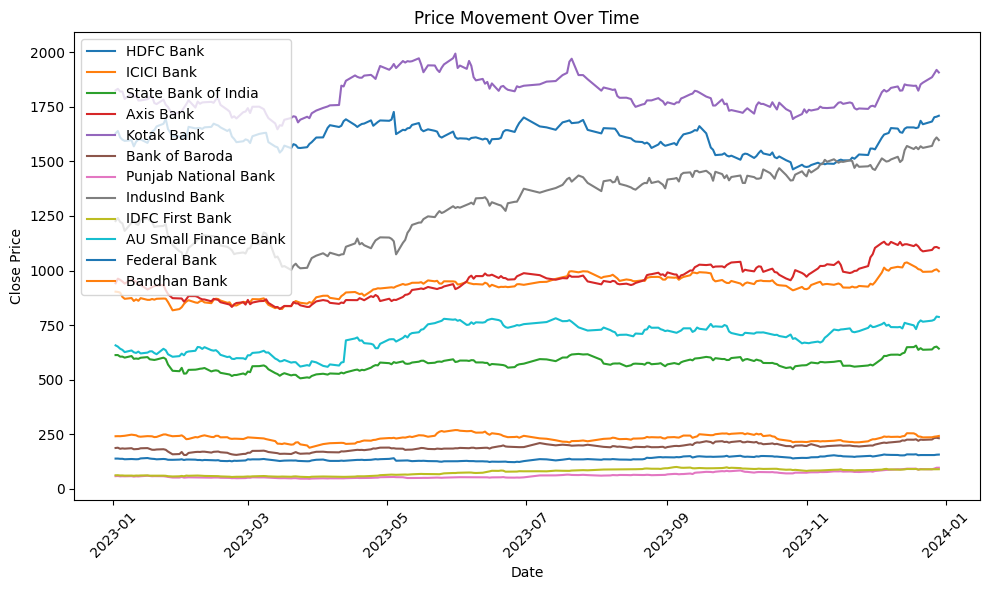

In [7]:
plt.figure(figsize=(10, 6))
for bank in df['Index'].unique():
    bank_data = df[df['Index'] == bank]
    plt.plot(bank_data['Date'], bank_data['Close'], label=bank)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Price Movement Over Time')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Moving Averages (10-day, 30-day)

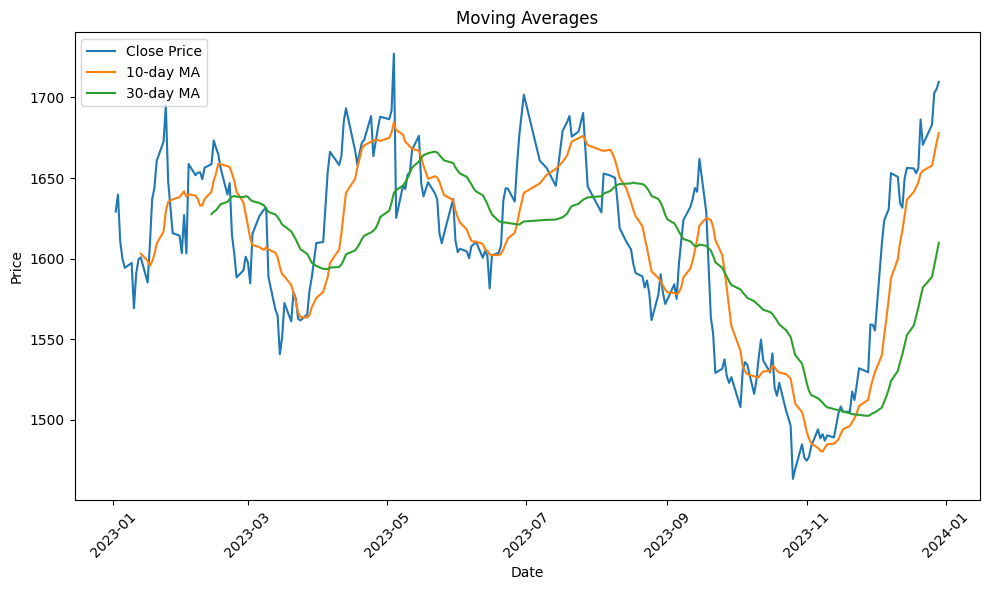

In [8]:
# Add moving averages for each bank
df['10_MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=10).mean())
df['30_MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=30).mean())

# Plot moving averages for a single bank (modify for others)
bank_data = df[df['Index'] == 'HDFC Bank']
plt.figure(figsize=(10, 6))
plt.plot(bank_data['Date'], bank_data['Close'], label='Close Price')
plt.plot(bank_data['Date'], bank_data['10_MA'], label='10-day MA')
plt.plot(bank_data['Date'], bank_data['30_MA'], label='30-day MA')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Moving Averages')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Daily Price Range

Box Plot for Price Volatility

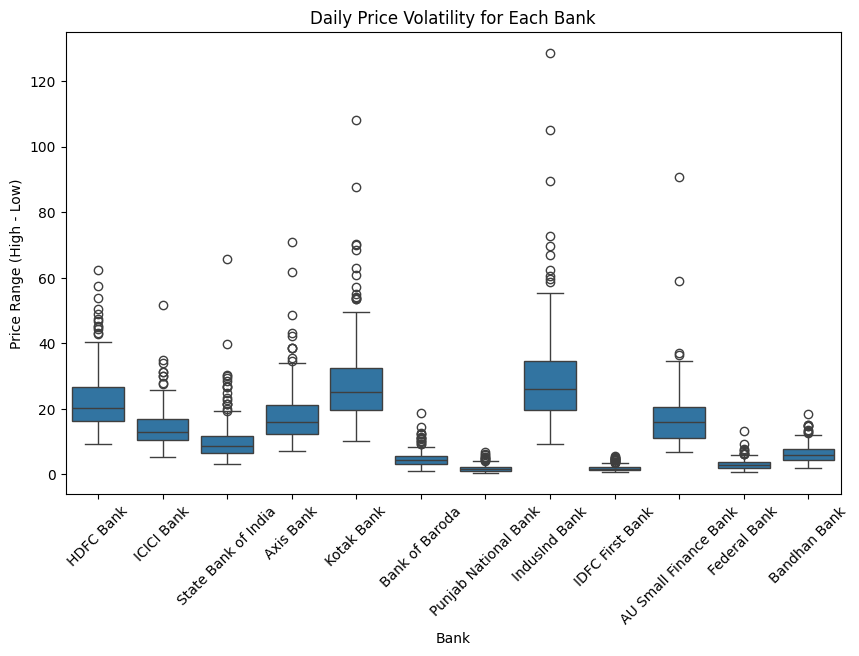

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Index', y=df['High'] - df['Low'], data=df)
plt.xticks(rotation=45)
plt.title('Daily Price Volatility for Each Bank')
plt.xlabel('Bank')
plt.ylabel('Price Range (High - Low)')
plt.show()


Volatility Analysis (Rolling Standard Deviation)

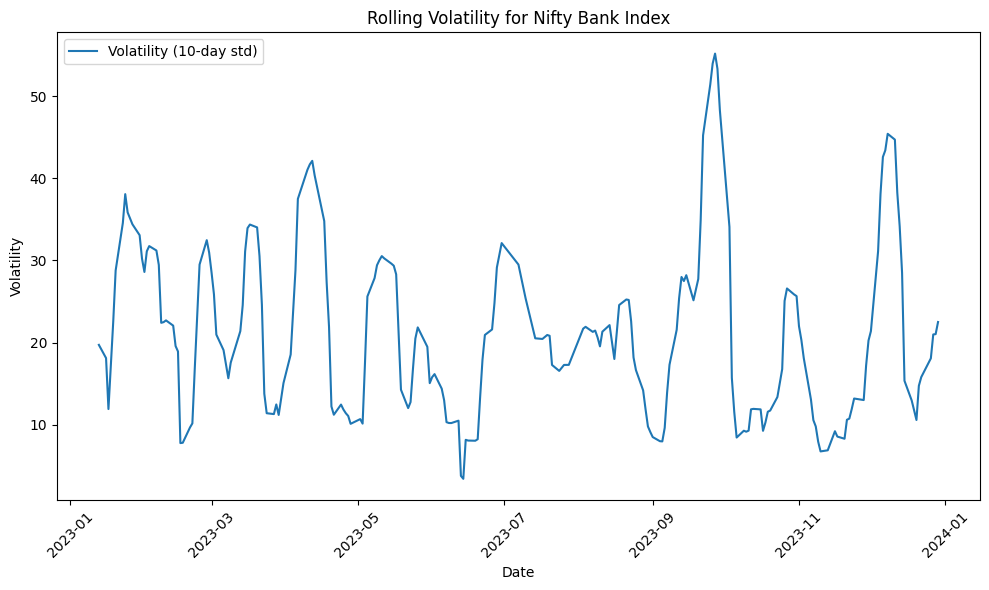

In [10]:
df['volatility'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=10).std())

# Plot volatility for a single bank
bank_data = df[df['Index'] == 'HDFC Bank']
plt.figure(figsize=(10, 6))
plt.plot(bank_data['Date'], bank_data['volatility'], label='Volatility (10-day std)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility for Nifty Bank Index')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Correlation Heatmap

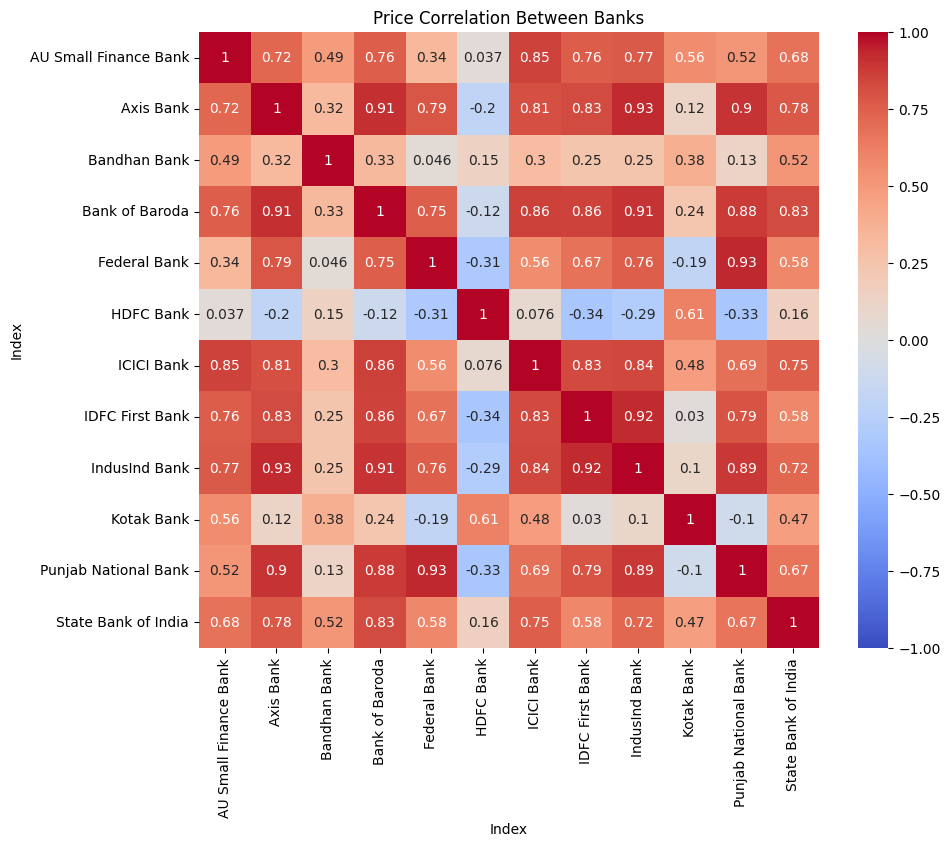

In [11]:
# Create a pivot table to get Close prices for each bank by date
pivot_data = df.pivot_table(values='Close', index='Date', columns='Index')

# Compute the correlation matrix
corr_matrix = pivot_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Price Correlation Between Banks')
plt.show()


Month-on-Month Price Comparison

Monthly Aggregation and Performance Bar Plot

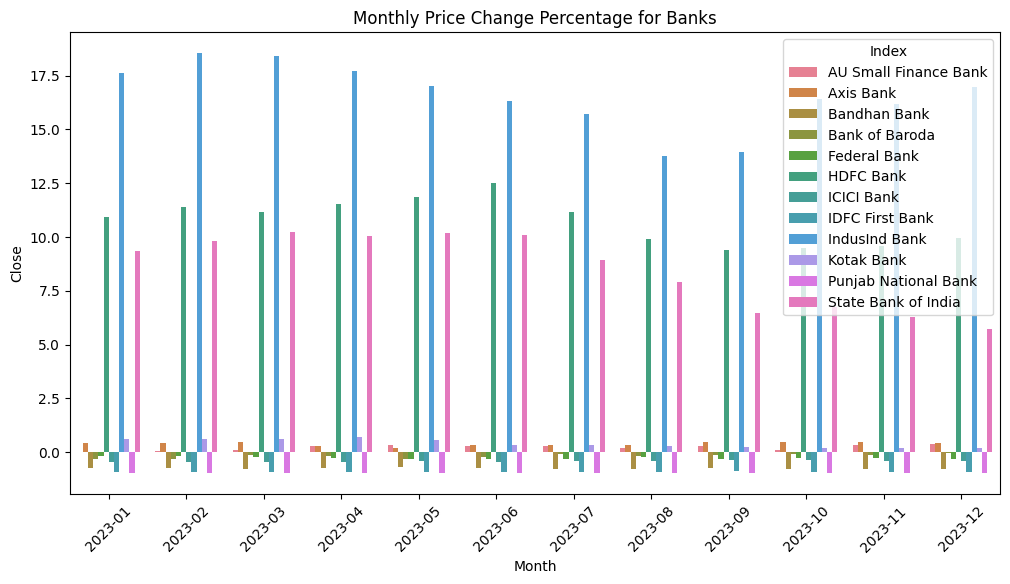

In [12]:
# Convert 'Date' column to datetime format and extract the month
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%Y-%m')

# Group by Month and Index to calculate monthly performance
monthly_performance = df.groupby(['Month', 'Index'])['Close'].last().pct_change().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Close', hue='Index', data=monthly_performance)
plt.xticks(rotation=45)
plt.title('Monthly Price Change Percentage for Banks')
plt.show()


Price Change Distribution

10. Relative Strength Index (RSI)

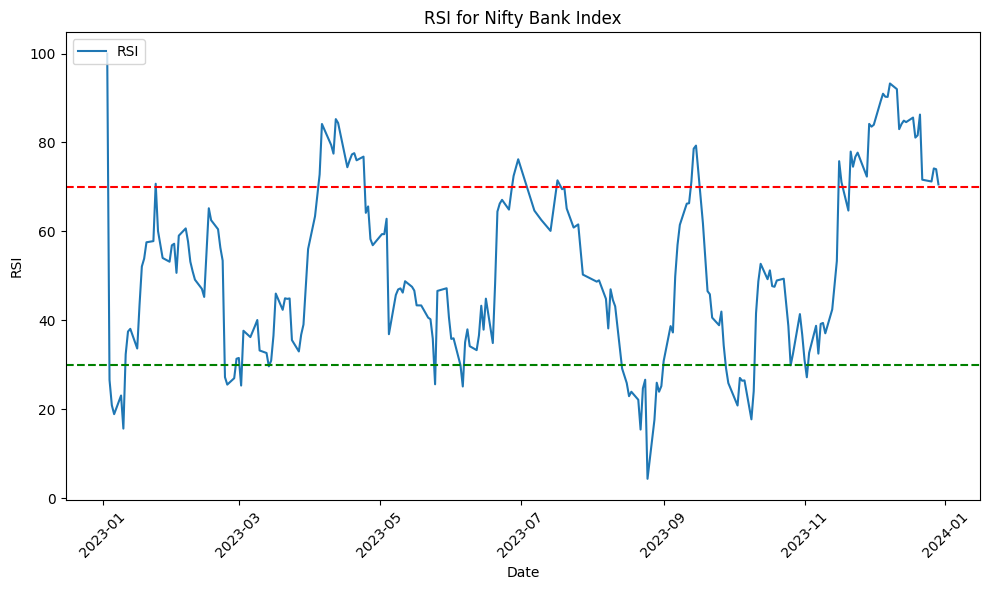

In [15]:
def calculate_RSI(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Index')['Close'].transform(calculate_RSI)

# Plot RSI for a single bank
bank_data = df[df['Index'] == "HDFC Bank"]
plt.figure(figsize=(10, 6))
plt.plot(bank_data['Date'], bank_data['RSI'], label='RSI')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI for Nifty Bank Index')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\Sailesh\AppData\Local\Temp\ipykernel_19796\1417833486.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = pivot_df.pct_change()


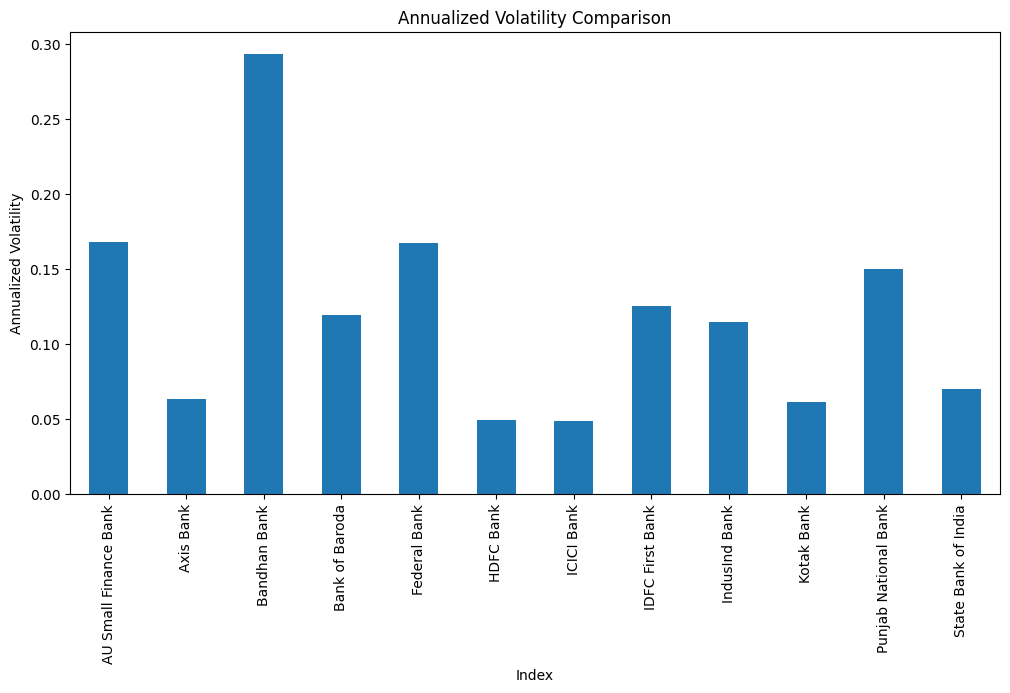

In [10]:
# Calculate daily returns
pivot_df = df.pivot_table(index=df.index, columns='Index', values='Close')
daily_returns = pivot_df.pct_change()

# Calculate annualized volatility
volatility = daily_returns.std() * (252**0.5)

plt.figure(figsize=(12, 6))
volatility.plot(kind='bar')
plt.title('Annualized Volatility Comparison')
plt.ylabel('Annualized Volatility')
plt.show()


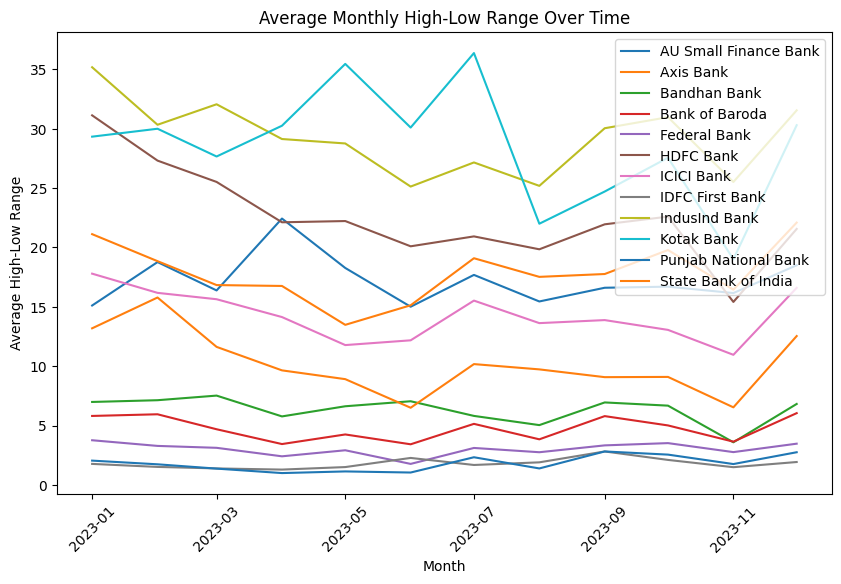

In [11]:
# Calculate daily high-low range
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df['High-Low Range'] = df['High'] - df['Low']

# Group by Index and Month, and calculate the mean of the high-low range
monthly_avg_range = df.groupby(['Index', 'Month'])['High-Low Range'].mean().reset_index()

# Convert the Month column back to datetime for proper plotting
monthly_avg_range['Month'] = pd.to_datetime(monthly_avg_range['Month'])

# Plot the average high-low range for each month
plt.figure(figsize=(10, 6))
for Index in monthly_avg_range['Index'].unique():
    Index_data = monthly_avg_range[monthly_avg_range['Index'] == Index]
    plt.plot(Index_data['Month'], Index_data['High-Low Range'], label=Index)

plt.title('Average Monthly High-Low Range Over Time')
plt.xlabel('Month')
plt.ylabel('Average High-Low Range')
plt.xticks(rotation=45)
plt.legend()
plt.show()


C:\Users\Sailesh\AppData\Local\Temp\ipykernel_16856\658854319.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_returns = df.groupby(['Index', 'Month'])['daily_return'].mean().reset_index()


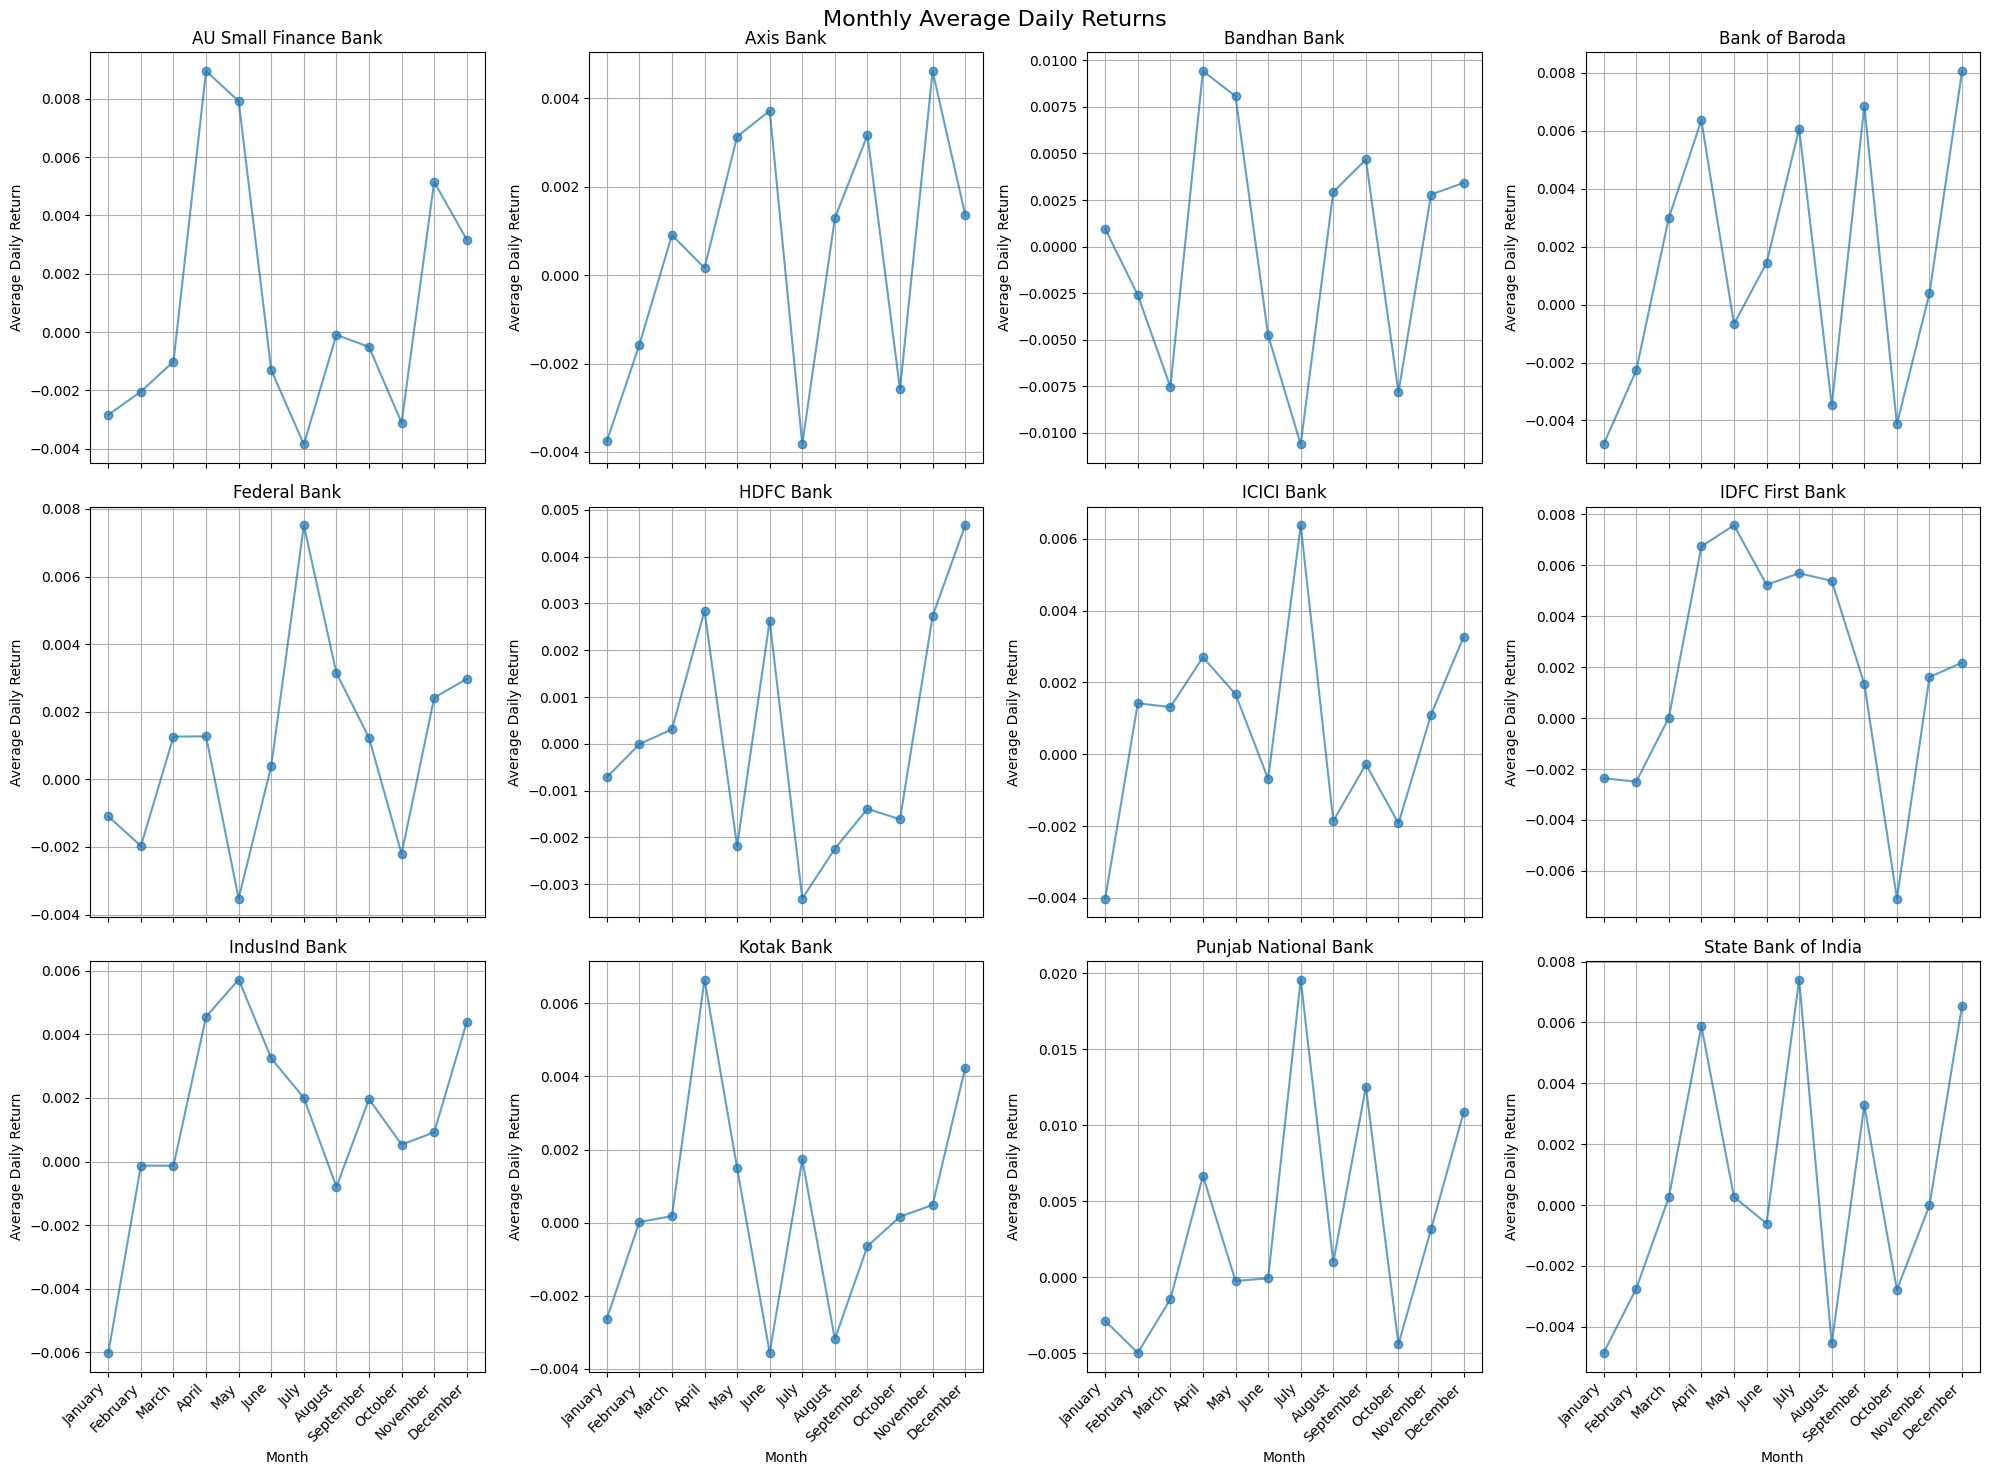

In [19]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Calculate daily returns for each index
df['daily_return'] = df.groupby('Index')['Close'].pct_change()

# Extract month and year from the 'Date' column
df['Month'] = df['Date'].dt.strftime('%B')

# Create an ordered list of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
               'September', 'October', 'November', 'December']

# Convert the 'Month' column to a categorical type with the specified order
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Group by month and index, then aggregate daily returns (mean for each month per index)
monthly_returns = df.groupby(['Index', 'Month'])['daily_return'].mean().reset_index()

# Get unique indices
indices = monthly_returns['Index'].unique()

# Set the number of rows and columns
num_rows = 3
num_cols = 4

# Create subplots with 3 rows and 4 columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), sharex=True)

fig.suptitle('Monthly Average Daily Returns', fontsize=16)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each index in a separate subplot
for i, index in enumerate(indices):
    ax = axes[i]
    index_data = monthly_returns[monthly_returns['Index'] == index]
    
    # Plot with the correct month order
    ax.plot(index_data['Month'].astype(str), index_data['daily_return'], marker='o', linestyle='-', alpha=0.7)
    ax.set_title(index)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Daily Return')
    ax.grid(True)
    
    if i >= len(axes) - num_cols:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate labels for the last row
    else:
        ax.set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()


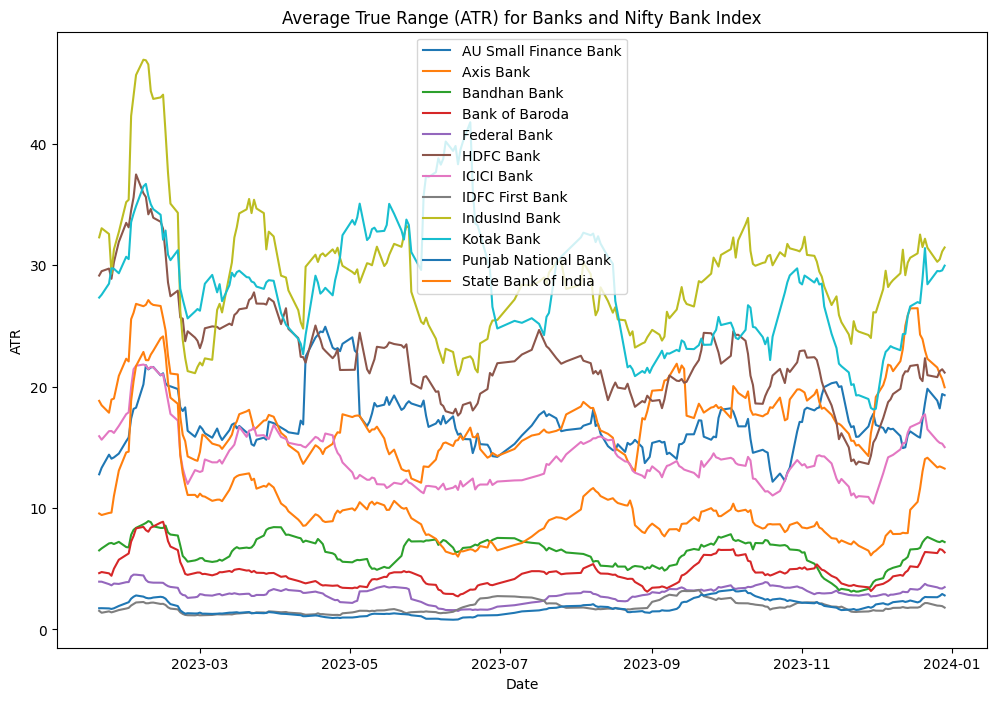

In [12]:
# Plot ATR for each bank and Nifty Bank Index
plt.figure(figsize=(12, 8))
for name, group in df.groupby('Index'):
    plt.plot(group['Date'], group['ATR'], label=name)

plt.title('Average True Range (ATR) for Banks and Nifty Bank Index')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.show()

In [16]:
# Calculate yearly percentage change for each bank
df['yearly_return'] = df.groupby('Index')['Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Rank banks based on yearly percentage change
yearly_performance = df.groupby('Index')['yearly_return'].last().sort_values(ascending=False)
print(yearly_performance)


Index
Punjab National Bank     67.611546
IDFC First Bank          45.482818
IndusInd Bank            30.272284
Bank of Baroda           24.080540
AU Small Finance Bank    19.832509
Axis Bank                17.154383
Federal Bank             13.367243
ICICI Bank               10.348839
HDFC Bank                 4.941227
State Bank of India       4.850962
Kotak Bank                4.504751
Bandhan Bank              0.499693
Name: yearly_return, dtype: float64


In [15]:
# Calculate annual growth rate (ROI)
df['Yearly ROI (%)'] = df.groupby('Index')['Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Summary of ROI per Index
roi_summary = df.groupby('Index')['Yearly ROI (%)'].first()
print(roi_summary)


Index
AU Small Finance Bank    19.832509
Axis Bank                17.154383
Bandhan Bank              0.499693
Bank of Baroda           24.080540
Federal Bank             13.367243
HDFC Bank                 4.941227
ICICI Bank               10.348839
IDFC First Bank          45.482818
IndusInd Bank            30.272284
Kotak Bank                4.504751
Punjab National Bank     67.611546
State Bank of India       4.850962
Name: Yearly ROI (%), dtype: float64


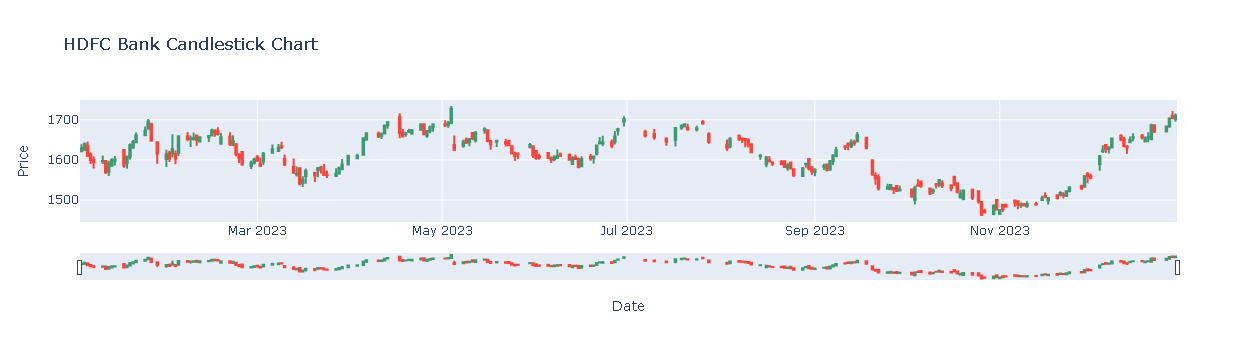

In [14]:
import plotly.graph_objects as go

# Plot a candlestick chart for a specific bank (e.g., HDFC Bank)
df_bank = df[df['Index'] == 'HDFC Bank']
fig = go.Figure(data=[go.Candlestick(x=df_bank['Date'],
                                     open=df_bank['Open'],
                                     high=df_bank['High'],
                                     low=df_bank['Low'],
                                     close=df_bank['Close'])])

fig.update_layout(title='HDFC Bank Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


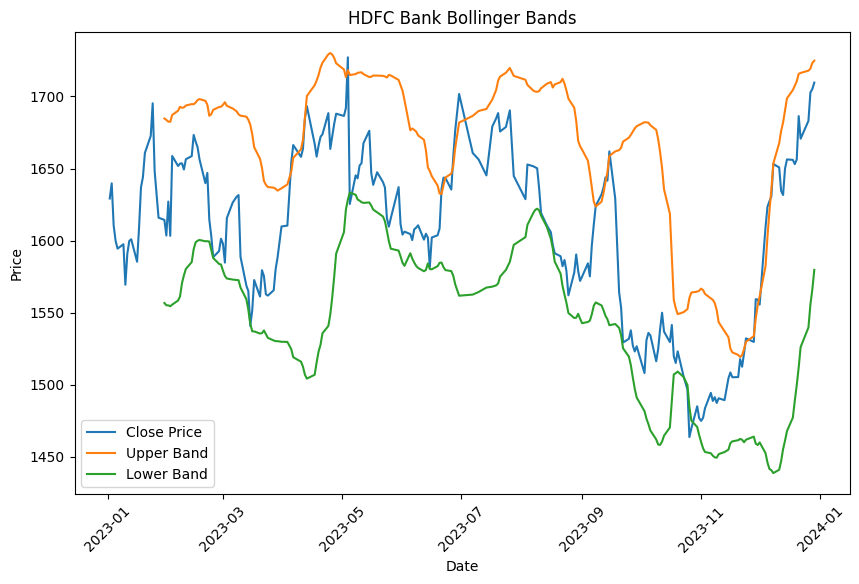

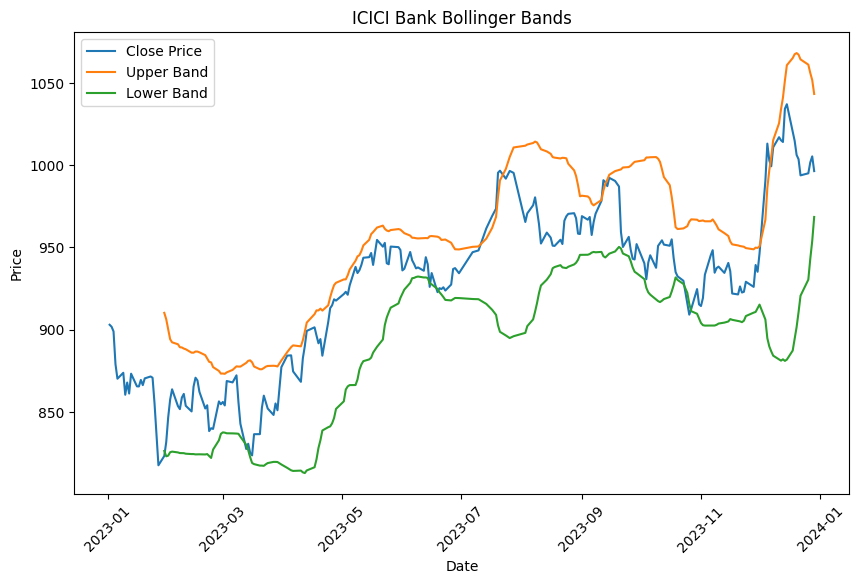

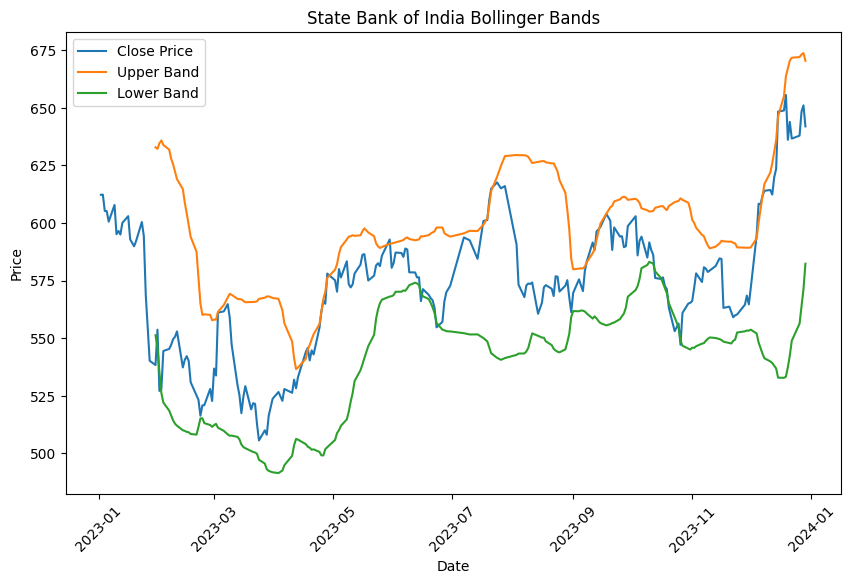

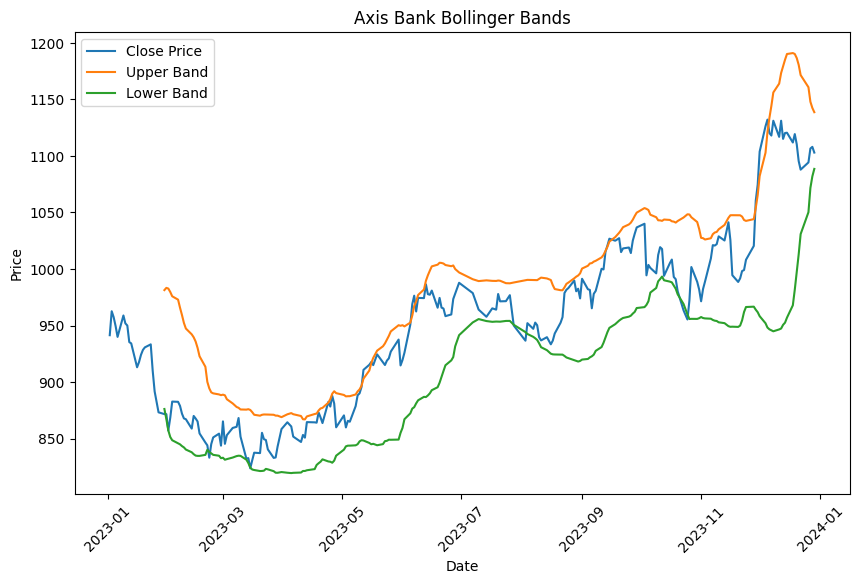

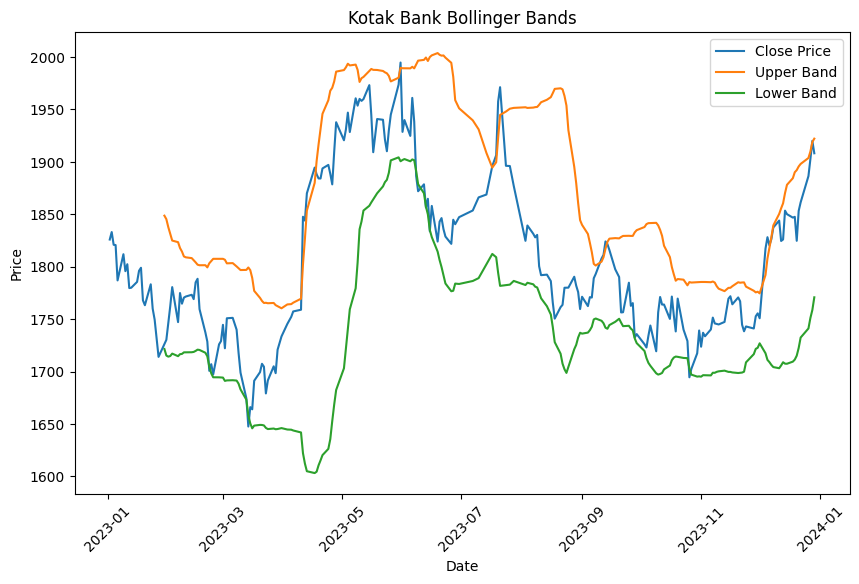

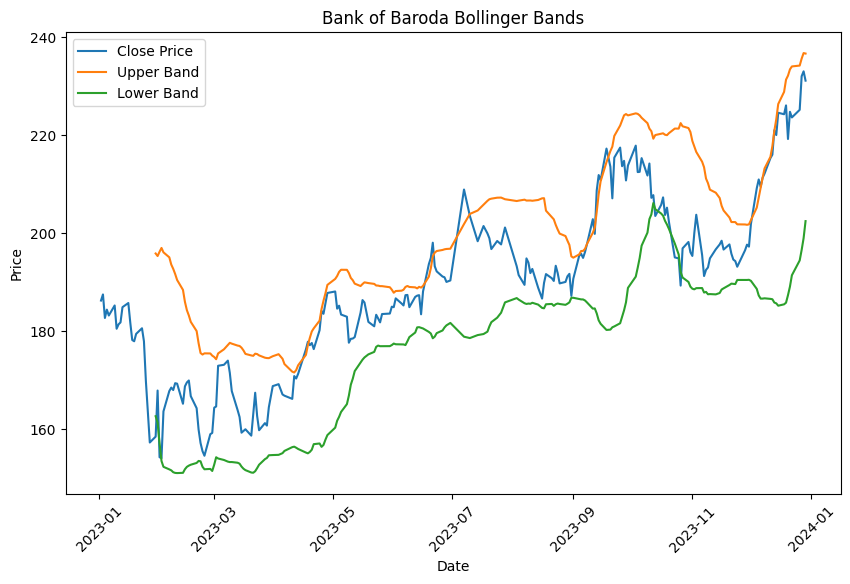

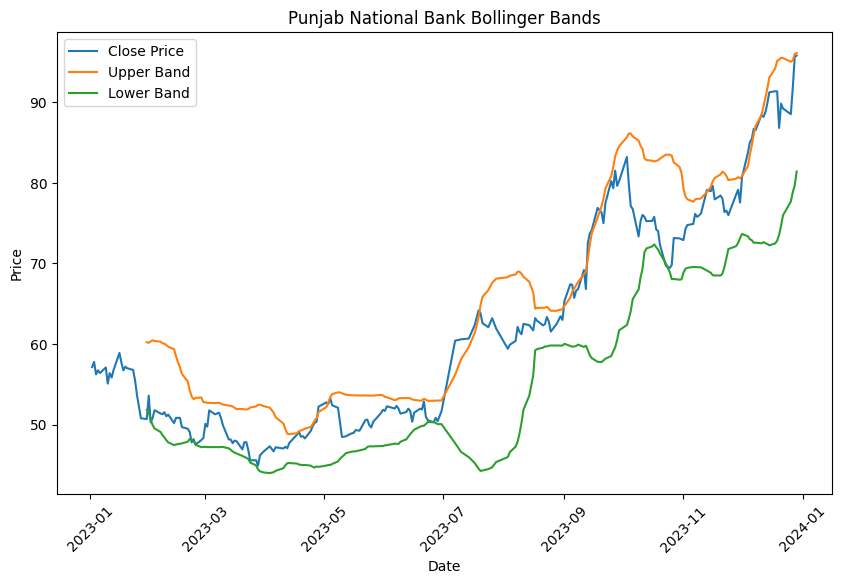

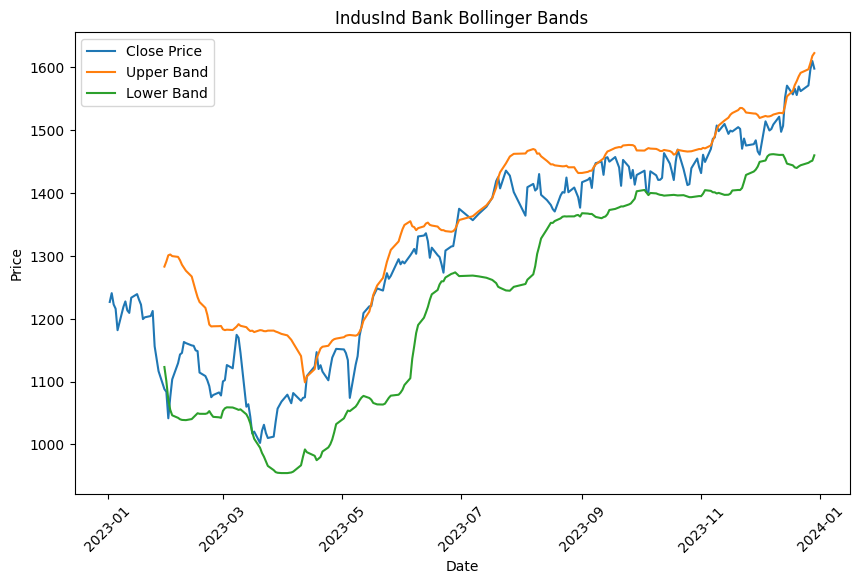

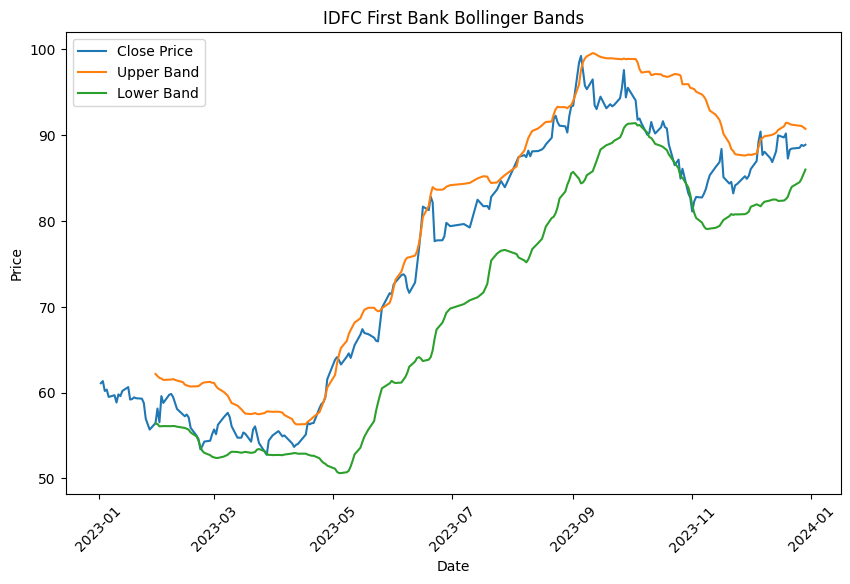

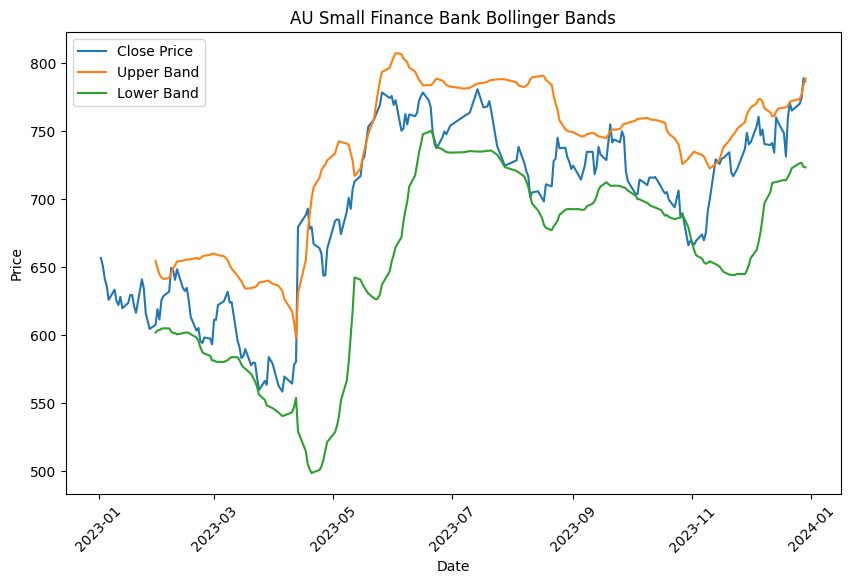

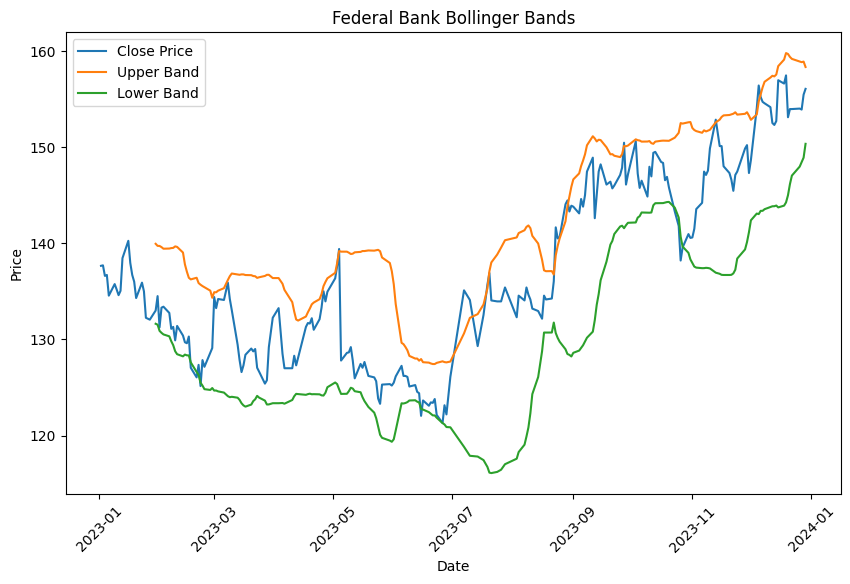

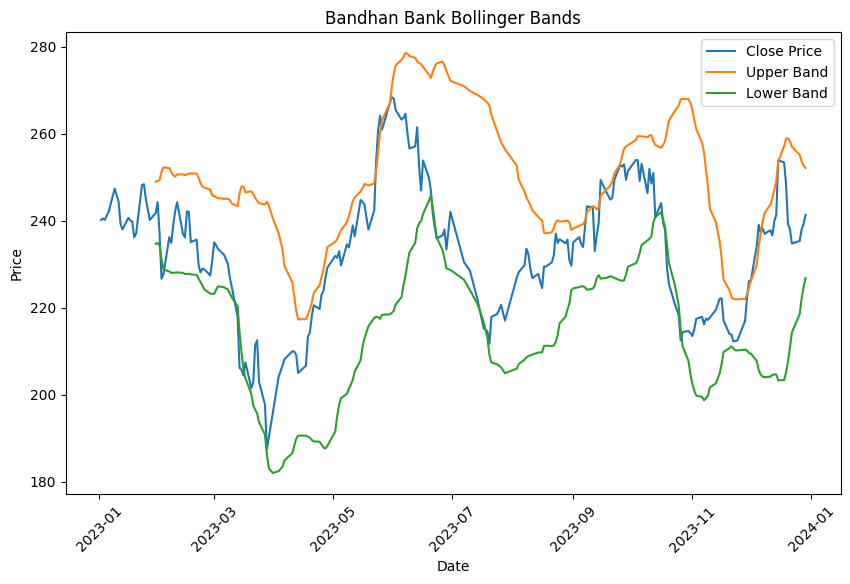

In [13]:
# Bollinger Bands
df['20 Day MA'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=20).mean())
df['20 Day Std'] = df.groupby('Index')['Close'].transform(lambda x: x.rolling(window=20).std())
df['Upper Band'] = df['20 Day MA'] + (df['20 Day Std'] * 2)
df['Lower Band'] = df['20 Day MA'] - (df['20 Day Std'] * 2)

# Plot Bollinger Bands for each Index
for Index in df['Index'].unique():
    Index_data = df[df['Index'] == Index]
    plt.figure(figsize=(10, 6))
    plt.plot(Index_data['Date'], Index_data['Close'], label='Close Price')
    plt.plot(Index_data['Date'], Index_data['Upper Band'], label='Upper Band')
    plt.plot(Index_data['Date'], Index_data['Lower Band'], label='Lower Band')
    plt.title(f'{Index} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


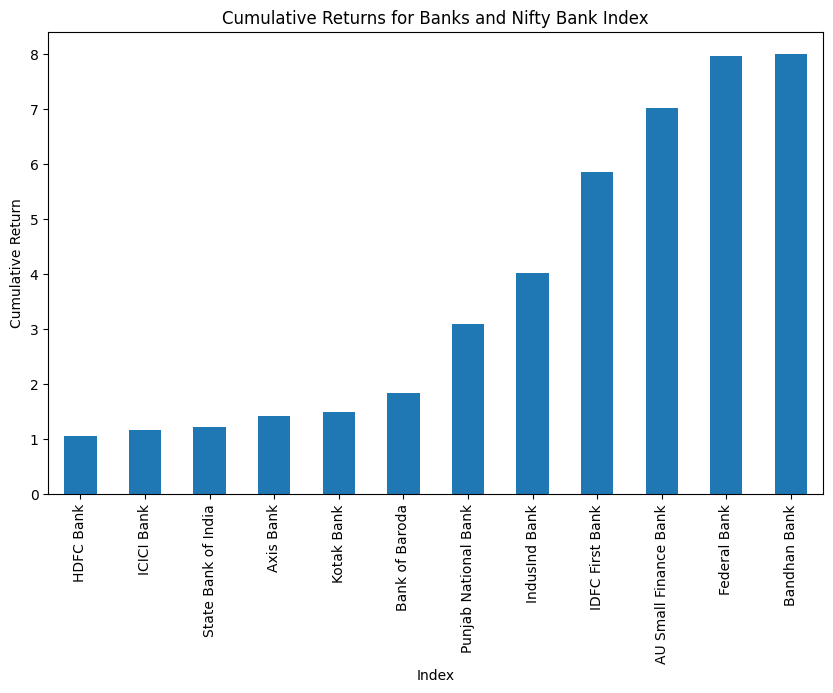

In [11]:
# Bar chart for cumulative returns at the end of the year
cumulative_returns_end = df.groupby('Index')['Cumulative_Return'].last().sort_values()
cumulative_returns_end.plot(kind='bar', figsize=(10, 6), title='Cumulative Returns for Banks and Nifty Bank Index')
plt.ylabel('Cumulative Return')
plt.show()

Support and Resistance levels

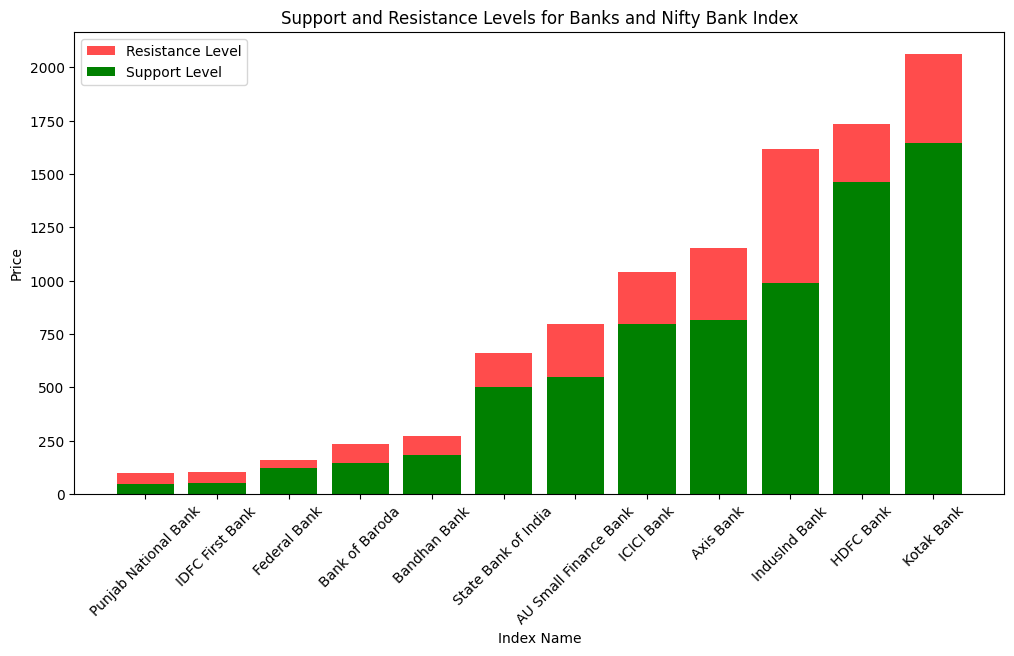

In [9]:
support_levels = df.groupby('Index')['Low'].min()
resistance_levels = df.groupby('Index')['High'].max()
sorted_indices = support_levels.sort_values().index
sorted_support_levels = support_levels[sorted_indices]
sorted_resistance_levels = resistance_levels[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(sorted_resistance_levels.index, sorted_resistance_levels, color='red', alpha=0.7, label='Resistance Level')
plt.bar(sorted_support_levels.index, sorted_support_levels, color='green', label='Support Level')
plt.title('Support and Resistance Levels for Banks and Nifty Bank Index')
plt.ylabel('Price')
plt.xlabel('Index Name')
plt.xticks(rotation=45)
plt.legend()
plt.show()